<a href="https://colab.research.google.com/github/JaquesZanon/JOB/blob/main/segmenta%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
### **Martins - Segmentação de Representantes**
**Autor:** `Jaques Zanon`

**e-mail:** `jaques.zanon@gmail.com`

![An image](https://logodownload.org/wp-content/uploads/2015/04/whatsapp-logo-6.png) `(11) 97251 6634`

---

In [ ]:
!pip install kneed
!pip install feature_engine
!pip install factor_analyzer
!pip install sklearn-som

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from kneed import KneeLocator
#from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
#from yellowbrick.cluster import KElbowVisualizer
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
#from sklearn.cluster import DBSCAN
#from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
#from scipy.cluster import hierarchy
from sklearn.decomposition import FactorAnalysis
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer import (ConfirmatoryFactorAnalyzer,
                              ModelSpecificationParser)
from sklearn_som.som import SOM
from io import StringIO

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#df = pd.read_csv(StringIO(mystr), header=None, sep='|')
df = pd.read_csv('/content/drive/MyDrive/JOB-Martins/segmento.txt', sep='|')
df = df.dropna()

In [ ]:
df.head()

,DtMovimento,NrPedido,IdClienteVenda,IdProduto,QtdeVendida,VlVendaLiquido,VlVendaBruto,VlTotalBruto,VlTotalLiquido,VlImpostos,CdCategoria,DsCategoria,CdSubCategoria,DsSubCategoria,IdRepComercial,DtCadastro,DsTipoPessoaRepresentante,DsTipoRepresentante,DsTerritorioVendas,DtCadastroRCA,DtSubstituicaoRepresentante,Vocaçao_dos_Municipios
0,2021-05-24,2974700.0,4391039.0,193931.0,1.0,74.10,78.41,78.41,74.10,13.96,71.0,SABAO/DETERGENTE PARA ROUPA,1.0,DETERGENTE EM PO,1171850.0,2016-12-08,PESSOA FÍSICA,VAREJO ALIMENTAR,BA_ITAPETINGA3_VAR_ATC,2016-12-08,2017-05-11,Núcleos Regionais
1,2021-05-24,2974700.0,4391039.0,216241.0,1.0,116.29,128.50,128.50,116.29,21.92,71.0,SABAO/DETERGENTE PARA ROUPA,1.0,DETERGENTE EM PO,1171850.0,2016-12-08,PESSOA FÍSICA,VAREJO ALIMENTAR,BA_ITAPETINGA3_VAR_ATC,2016-12-08,2017-05-11,Núcleos Regionais
2,2021-05-24,2993905.0,4542353.0,194950.0,3.0,25.99,26.93,80.79,77.97,19.92,14.0,SANDALIA,22.0,CASUAL,1241883.0,2020-02-18,PESSOA FÍSICA,VAREJO ALIMENTAR,BA_SALVADOR60_FAR_CAT,2020-02-18,2020-02-18,Metrópoles Desenvolvidas
3,2021-05-25,3002010.0,428799.0,215740.0,3.0,25.03,27.36,82.08,75.09,19.20,14.0,SANDALIA,22.0,CASUAL,1075456.0,2007-06-20,PESSOA FÍSICA,VAREJO ALIMENTAR,BA_SALVADOR19_VAR_ATC,2007-06-20,2010-07-16,Metrópoles Desenvolvidas
4,2021-05-26,3040084.0,6125928.0,209706.0,2.0,100.10,107.63,215.26,200.20,51.21,15.0,UTILIDADES DOMESTICAS,2.0,ESCADA DOMESTICA,1234508.0,2019-11-22,PESSOA FÍSICA,MARTCON,CE_FORTALEZA31_MAT_CAT,2019-11-22,2019-11-22,Metrópoles Desenvolvidas


In [ ]:
#df = pd.read_csv("/content/drive/MyDrive/JOB-Martins/segmentacao.csv",parse_dates=True)
#df = df[df['DtCadastroRCA'].notna()]
#df.head()

In [ ]:
df["DsTerritorioVendas"] = df["DsTerritorioVendas"].str.split("_", n = 1, expand = True).iloc[:,0].copy()

In [143]:
df["DsTerritorioVendas"]

0          4
1          4
2          4
3          4
4          3
          ..
6615545    7
6615546    2
6615547    7
6615548    5
6615549    7
Name: DsTerritorioVendas, Length: 6493405, dtype: object

### Para gerar a codificação de estados.



In [ ]:
mapping = {'DF': 1, 
           'GO': 1,
           'MS': 1,
           'MT': 1, 
           'AC': 2,
           'AM': 2,
           'AP': 2, 
           'PA': 2,
           'RO': 2,
           'RR': 2, 
           'TO': 2,
           'MA': 3,
           'PI': 3, 
           'CE': 3,
           'RN': 3,
           'PB': 3, 
           'PE': 3,
           'AL': 3,
           'SE': 4, 
           'BA': 4,
           'PR': 5,
           'SC': 5, 
           'RS': 5,
           'ES': 6,
           'RJ': 6,
           'MG': 7,
           'SP': 8}

In [ ]:
df = df.replace({'DsTerritorioVendas': mapping})
df = df[df['DsTerritorioVendas'].astype(str).str.isdigit()]

### Para gerar a codificação da vocação de municípios.

In [ ]:
mapping = {'São Paulo': 1, 
           'Rio de Janeiro': 1,
           'Metrópoles Desenvolvidas': 1,
           'Centros Urbanos Consolidados': 2, 
           'Centros Urbanos Secundários': 2,
           'Pólos Industriais': 2,
           'Núcleos Regionais': 2,
           'Pólos Turísticos': 2,
           'Pólos de Agroindústria': 3,
           'Rural Desenvolvido': 3,
           'Movimento Iminente' : 3,
           'Núcleos Agropecuários': 4,
           'Em Busca de Oportunidades': 4,
           'Carentes de Recursos': 4}
df = df.replace({'Vocaçao_dos_Municipios': mapping})

# Calculando variaveis auxiliares

In [ ]:
# Tempo_Expo
df.DtCadastroRCA = pd.to_datetime(df.DtCadastroRCA).copy()
df.DtMovimento = pd.to_datetime(df.DtMovimento).copy()


In [211]:
(df['DtMovimento'] - df['DtCadastroRCA']).dt.days/30.5

0           53.377049
1           53.377049
2           15.114754
3          166.819672
4           18.065574
              ...    
6615545    134.918033
6615546    157.737705
6615547      8.786885
6615548    186.786885
6615549     16.393443
Length: 6493405, dtype: float64

### Calculando tempo de explosição

In [212]:
df['Tempo_Expo'] = (df['DtMovimento'] - df['DtCadastroRCA']).dt.days/30.5
#df.assign(Tempo_expo = pd.to_numeric(df.DtMovimento  - df.DtCadastroRCA)).copy()
df.Tempo_Expo[df.Tempo_Expo>12]=12
df.Tempo_Expo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0          12.000000
1          12.000000
2          12.000000
3          12.000000
4          12.000000
             ...    
6615545    12.000000
6615546    12.000000
6615547     8.786885
6615548    12.000000
6615549    12.000000
Name: Tempo_Expo, Length: 6493405, dtype: float64

In [221]:
12 if list(df.Tempo_Expo)>12 else list(df.Tempo_Expo)

TypeError: ignored

In [ ]:
#Total_VLRecLiq_Reg 
Total_VLRecLiq_Reg = df.groupby(['DsTerritorioVendas'])[['VlVendaLiquido']].agg('sum')

In [ ]:
mapping = {'VAREJO ALIMENTAR                        ': 4, 
           'MARTCON                                 ': 3,
           'FARMA NACIONAL                          ': 2,
           'INFORMATICA                             ': 1, 
           'ELETRO                                  ': 1,
           'VETERINARIO                             ': 3
           }

In [ ]:
df = df.replace({'DsTipoRepresentante': mapping})

In [ ]:
#Total_VLRecLiq_TipoRepr 
Total_VLRecLiq_TipoRepr = df.groupby(['DsTipoRepresentante'])[['VlVendaLiquido']].agg('sum')

In [ ]:
#Média_QteClientes_TipoRepr
Media_QteClientes_TipoRepr = df.groupby(['DsTipoRepresentante'])[['IdClienteVenda']].nunique()
#df.groupby(['DsTipoNegocioRepresentanteComercial'])[['IdClienteEntrega']].count()
#df.groupby(['DsTipoNegocioRepresentanteComercial'])[['IdRepComercial']].count()
Media_QteClientes_TipoRepr



,IdClienteVenda
DsTipoRepresentante,
1,3494
2,1984
3,10432
4,74767


In [ ]:
#Média_QteProduto_TipoRepr
Media_QteProduto_TipoRepr = df.groupby(['DsTipoRepresentante','NrPedido'])[['QtdeVendida']].mean().groupby(['DsTipoRepresentante'])[['QtdeVendida']].mean()
Media_QteProduto_TipoRepr

,QtdeVendida
DsTipoRepresentante,
1,8.663001
2,21.004208
3,6.911532
4,16.376437


In [ ]:
#Média_QteCategoria_TipoRepr
Media_QteCategoria_TipoRepr = df.groupby(['DsTipoRepresentante'])[['CdCategoria']].nunique()
Media_QteCategoria_TipoRepr

,CdCategoria
DsTipoRepresentante,
1,78
2,75
3,78
4,80


In [ ]:
#Media_QtePedidos_TipoRepr
Media_QtePedidos_TipoRepr = df.groupby(['DsTipoRepresentante','Tempo_Expo'])[['NrPedido']].nunique().groupby(['DsTipoRepresentante'])[['NrPedido']].mean()
Media_QtePedidos_TipoRepr

,NrPedido
DsTipoRepresentante,
1,6.312058
2,7.342373
3,13.061009
4,54.740211


In [ ]:
#df.DsCategoria.unique()

### Variaveis segmentadoras


In [ ]:
#V1 Valor da Receita Líquida do Vendedor pelo período de exposição:
V1 = df.groupby(['IdRepComercial'])[['VlVendaLiquido']].sum().loc[:,'VlVendaLiquido']/df.groupby(['IdRepComercial'])[['Tempo_Expo']].mean().loc[:,'Tempo_Expo']
V1 = pd.DataFrame(V1).reset_index()
V1

,IdRepComercial,0
0,1051912.0,4.596334e-13
1,1052190.0,5.026031e-13
2,1053746.0,1.850112e-13
3,1053821.0,2.143411e-13
4,1054692.0,3.313165e-15
...,...,...
2036,1278808.0,3.052510e-11
2037,1278809.0,8.457837e-12
2038,1278811.0,3.124586e-12
2039,1278812.0,4.250881e-12


In [ ]:
#df[(df.CdEstadoTerritorioVendas == 2) & (df.CdEstadoTerritorioVendas == 1)]
#df["A"][(df["B"] > 50) & (df["C"] == 900)]

In [ ]:
#V2 = Importância da receita líquida do Vendedor na região que ele pertence:
rec_reg=df.groupby(['DsTerritorioVendas'])[['VlVendaLiquido']].sum().loc[:,'VlVendaLiquido']
V2 = pd.DataFrame(df.groupby(['DsTerritorioVendas','IdRepComercial'])[['VlVendaLiquido']].sum().loc[:,"VlVendaLiquido"]/rec_reg.iloc[0]).reset_index().groupby(['IdRepComercial'])[['VlVendaLiquido']].mean()
V2 = pd.DataFrame(V2).reset_index()
V2

,IdRepComercial,VlVendaLiquido
0,1051912.0,0.008200
1,1052190.0,0.008798
2,1053746.0,0.003154
3,1053821.0,0.003650
4,1054692.0,0.000055
...,...,...
2036,1278808.0,0.010925
2037,1278809.0,0.003041
2038,1278811.0,0.000930
2039,1278812.0,0.001145


In [ ]:
#V3 Importância da receita líquida do Vendedor categoria Tipo de Representante (Negócio)
rec_area_negocio=df.groupby(['DsTipoRepresentante'])[['VlVendaLiquido']].sum().loc[:,'VlVendaLiquido']
V3 = pd.DataFrame(df[df.DsTipoRepresentante == 1].groupby(['IdRepComercial'])[['VlVendaLiquido']].sum().loc[:,"VlVendaLiquido"]/rec_area_negocio.iloc[0]).append([
pd.DataFrame(df[df.DsTipoRepresentante == 2].groupby(['IdRepComercial'])[['VlVendaLiquido']].sum().loc[:,"VlVendaLiquido"]/rec_area_negocio.iloc[1]),
pd.DataFrame(df[df.DsTipoRepresentante == 3].groupby(['IdRepComercial'])[['VlVendaLiquido']].sum().loc[:,"VlVendaLiquido"]/rec_area_negocio.iloc[2]),
pd.DataFrame(df[df.DsTipoRepresentante == 4].groupby(['IdRepComercial'])[['VlVendaLiquido']].sum().loc[:,'VlVendaLiquido']/rec_area_negocio.iloc[3])]).reset_index()
V3 = V3*100
V3 

,IdRepComercial,VlVendaLiquido
0,106900700.0,0.801952
1,107167200.0,0.124029
2,107365000.0,0.032864
3,108541000.0,1.448659
4,108543100.0,1.684513
...,...,...
2036,127880700.0,0.043880
2037,127880800.0,0.215401
2038,127880900.0,0.059950
2039,127881100.0,0.018344


In [ ]:
# V4 Vocaçao_dos_Municipios
rec_vocacao=df.groupby(['Vocaçao_dos_Municipios'])[['VlVendaLiquido']].sum().loc[:,'VlVendaLiquido']
V4 = pd.DataFrame(df[df.Vocaçao_dos_Municipios == 1].groupby(['IdRepComercial'])[['VlVendaLiquido']].sum().loc[:,"VlVendaLiquido"]/rec_vocacao.iloc[0]).append([
pd.DataFrame(df[df.Vocaçao_dos_Municipios == 2].groupby(['IdRepComercial'])[['VlVendaLiquido']].sum().loc[:,"VlVendaLiquido"]/rec_vocacao.iloc[1]),
pd.DataFrame(df[df.Vocaçao_dos_Municipios == 3].groupby(['IdRepComercial'])[['VlVendaLiquido']].sum().loc[:,"VlVendaLiquido"]/rec_vocacao.iloc[2]),
pd.DataFrame(df[df.Vocaçao_dos_Municipios == 4].groupby(['IdRepComercial'])[['VlVendaLiquido']].sum().loc[:,'VlVendaLiquido']/rec_vocacao.iloc[3])]).reset_index()
V4 = V4.groupby(['IdRepComercial'])[['VlVendaLiquido']].mean()
V4 = V4*100
V4 = pd.DataFrame(V4).reset_index()
V4

,IdRepComercial,VlVendaLiquido
0,1051912.0,0.281549
1,1052190.0,1.767720
2,1053746.0,0.546954
3,1053821.0,0.125327
4,1054692.0,0.002109
...,...,...
2036,1278808.0,0.375094
2037,1278809.0,0.104396
2038,1278811.0,0.161317
2039,1278812.0,0.039330


In [ ]:
#V5 Quantidade de clientes atendidos pelo vendedor em relação a sua categoria Tipo de Representante 
#Média_QteClientes_TipoRepr
V5 = pd.DataFrame(df[df.DsTipoRepresentante == 1].groupby(['IdRepComercial'])[['IdClienteVenda']].nunique().loc[:,"IdClienteVenda"]/Media_QteClientes_TipoRepr.iloc[0,0]).append([
pd.DataFrame(df[df.DsTipoRepresentante == 2].groupby(['IdRepComercial'])[['IdClienteVenda']].nunique().loc[:,"IdClienteVenda"]/Media_QteClientes_TipoRepr.iloc[1,0]),
pd.DataFrame(df[df.DsTipoRepresentante == 3].groupby(['IdRepComercial'])[['IdClienteVenda']].nunique().loc[:,"IdClienteVenda"]/Media_QteClientes_TipoRepr.iloc[2,0]),
pd.DataFrame(df[df.DsTipoRepresentante == 4].groupby(['IdRepComercial'])[['IdClienteVenda']].nunique().loc[:,"IdClienteVenda"]/Media_QteClientes_TipoRepr.iloc[3,0])]).reset_index()
V5

,IdRepComercial,IdClienteVenda
0,1069007.0,0.013165
1,1071672.0,0.004579
2,1073650.0,0.000572
3,1085410.0,0.012021
4,1085431.0,0.013452
...,...,...
2036,1278807.0,0.000308
2037,1278808.0,0.000816
2038,1278809.0,0.000508
2039,1278811.0,0.000602


In [ ]:
# V6 Quantidade de itens por quantidade em relação ao Tipo de Representante
V6 = pd.DataFrame(df[df.DsTipoRepresentante == 1].groupby(['IdRepComercial'])[['QtdeVendida']].sum().loc[:,"QtdeVendida"]/Media_QteProduto_TipoRepr.iloc[0,0]).append([
pd.DataFrame(df[df.DsTipoRepresentante == 2].groupby(['IdRepComercial'])[['QtdeVendida']].sum().loc[:,"QtdeVendida"]/Media_QteProduto_TipoRepr.iloc[1,0]),
pd.DataFrame(df[df.DsTipoRepresentante == 3].groupby(['IdRepComercial'])[['QtdeVendida']].sum().loc[:,"QtdeVendida"]/Media_QteProduto_TipoRepr.iloc[2,0]),
pd.DataFrame(df[df.DsTipoRepresentante == 4].groupby(['IdRepComercial'])[['QtdeVendida']].sum().loc[:,"QtdeVendida"]/Media_QteProduto_TipoRepr.iloc[3,0])]).reset_index()
V6 

,IdRepComercial,QtdeVendida
0,1069007.0,1817.961135
1,1071672.0,58.524750
2,1073650.0,191.042332
3,1085410.0,358.305376
4,1085431.0,466.235636
...,...,...
2036,1278807.0,1179.377420
2037,1278808.0,1745.068235
2038,1278809.0,4775.580918
2039,1278811.0,600.374795


In [ ]:
#V7 Quantidade de Categorias diferentes que vendidas pelo vendedor no período, relativo a categoria de Tipo de Representante
V7 = pd.DataFrame(df[df.DsTipoRepresentante == 1].groupby(['IdRepComercial'])[['DsCategoria']].nunique().loc[:,"DsCategoria"]/Media_QteCategoria_TipoRepr.iloc[0,0]).append([
pd.DataFrame(df[df.DsTipoRepresentante == 2].groupby(['IdRepComercial'])[['DsCategoria']].nunique().loc[:,"DsCategoria"]/Media_QteCategoria_TipoRepr.iloc[1,0]),
pd.DataFrame(df[df.DsTipoRepresentante == 3].groupby(['IdRepComercial'])[['DsCategoria']].nunique().loc[:,"DsCategoria"]/Media_QteCategoria_TipoRepr.iloc[2,0]),
pd.DataFrame(df[df.DsTipoRepresentante == 4].groupby(['IdRepComercial'])[['DsCategoria']].nunique().loc[:,"DsCategoria"]/Media_QteCategoria_TipoRepr.iloc[3,0])]).reset_index()
V7 


,IdRepComercial,DsCategoria
0,1069007.0,1.243590
1,1071672.0,0.358974
2,1073650.0,0.064103
3,1085410.0,0.333333
4,1085431.0,0.525641
...,...,...
2036,1278807.0,1.412500
2037,1278808.0,1.825000
2038,1278809.0,1.587500
2039,1278811.0,0.575000


In [ ]:
#V8 
V8 = pd.DataFrame((df[df.DsTipoRepresentante == 1].groupby(['IdRepComercial'])[['NrPedido']].nunique().reset_index().loc[:,"NrPedido"]/df[df.DsTipoRepresentante == 1].groupby(['IdRepComercial'])[['Tempo_Expo']].mean().reset_index().loc[:,"Tempo_Expo"])/Media_QtePedidos_TipoRepr.iloc[0,0]).append([
pd.DataFrame((df[df.DsTipoRepresentante == 2].groupby(['IdRepComercial'])[['NrPedido']].nunique().reset_index().loc[:,"NrPedido"]/df[df.DsTipoRepresentante == 2].groupby(['IdRepComercial'])[['Tempo_Expo']].mean().reset_index().loc[:,"Tempo_Expo"])/Media_QtePedidos_TipoRepr.iloc[1,0]),
pd.DataFrame((df[df.DsTipoRepresentante == 3].groupby(['IdRepComercial'])[['NrPedido']].nunique().reset_index().loc[:,"NrPedido"]/df[df.DsTipoRepresentante == 3].groupby(['IdRepComercial'])[['Tempo_Expo']].mean().reset_index().loc[:,"Tempo_Expo"])/Media_QtePedidos_TipoRepr.iloc[2,0]),
pd.DataFrame((df[df.DsTipoRepresentante == 4].groupby(['IdRepComercial'])[['NrPedido']].nunique().reset_index().loc[:,"NrPedido"]/df[df.DsTipoRepresentante == 4].groupby(['IdRepComercial'])[['Tempo_Expo']].mean().reset_index().loc[:,"Tempo_Expo"])/Media_QtePedidos_TipoRepr.iloc[3,0])])
V8 = V8.reset_index()
V8.columns = ['index', "V8"]
V8

,index,V8
0,0,0.081559
1,1,0.007892
2,2,0.003660
3,3,0.171007
4,4,0.210868
...,...,...
2036,1685,0.190095
2037,1686,1.095022
2038,1687,0.340848
2039,1688,0.251799


In [178]:
var_seg = pd.concat([V2.loc[:,'VlVendaLiquido'], V3.loc[:,'VlVendaLiquido'],V4.loc[:,'VlVendaLiquido'], V5.loc[:,'IdClienteVenda'],V6.loc[:,'QtdeVendida'],V7.loc[:,'DsCategoria'],V8.loc[:,"V8"]], axis=1)
var_seg.columns = ['rep_comercial','V2', 'V3', "V4", 'V5',"V6","V7","V8"]
var_seg.index = var_seg['rep_comercial']
var_seg = var_seg.drop("rep_comercial", axis=1)

ValueError: ignored

In [ ]:
var_seg.describe().round(5)

,V1,V2,V3,V4,V5,V6,V7,V8
count,2041.0,2041.00000,2041.00000,2041.00000,2041.00000,2041.00000,2041.00000,2041.00000
mean,0.0,0.00320,0.19598,0.19316,0.00196,1726.34031,1.06083,0.11117
std,0.0,0.00277,0.57933,0.27152,0.00475,3294.48839,0.47892,0.24171
min,0.0,0.00000,0.00002,0.00004,0.00001,0.12213,0.01250,0.00003
25%,0.0,0.00110,0.02461,0.04848,0.00037,428.72574,0.73077,0.01047
50%,0.0,0.00264,0.05963,0.11223,0.00067,1033.19177,1.13333,0.03189
75%,0.0,0.00455,0.12166,0.21110,0.00106,2041.51544,1.41250,0.10983
max,0.0,0.02460,11.30034,2.64027,0.06250,93899.30183,2.12500,3.60846


In [ ]:
num_vars = ['V1','V2','V3', 'V4', 'V5', 'V6','V7', 'V8']
std_scaler = SklearnTransformerWrapper(transformer=StandardScaler(),
                                      variables = num_vars)

In [ ]:
#std_scaler = SklearnTransformerWrapper(transformer=MinMaxScaler(),
#                                     variables = num_vars)

#### Padronizando Variáveis

In [176]:
df_aux_sc = std_scaler.fit_transform(var_seg)

In [177]:
df_aux_sc

,V1,V2,V3,V4,V5,V6,V7,V8
rep_comercial,,,,,,,,
1051912.0,-0.407686,1.806787,1.046231,0.325628,2.360096,0.027817,0.381694,-0.122547
1052190.0,-0.387156,2.023008,-0.124231,5.800444,0.551699,-0.506368,-1.465859,-0.427393
1053746.0,-0.538901,-0.017009,-0.281631,1.303336,-0.292220,-0.466134,-2.081710,-0.444905
1053821.0,-0.524887,0.162188,2.162797,-0.249870,2.118977,-0.415351,-1.519411,0.247605
1054692.0,-0.625716,-1.137348,2.570008,-0.703785,2.420376,-0.382582,-1.117769,0.412558
...,...,...,...,...,...,...,...,...
1278808.0,13.957558,2.791560,-0.262611,0.670232,-0.347989,-0.166064,0.734470,0.326594
1278809.0,3.413846,-0.058157,0.033527,-0.326976,-0.240943,0.005686,1.595992,4.071342
1278811.0,0.865625,-0.820891,-0.234865,-0.117287,-0.305734,0.925785,1.099964,0.950436


### Testes para verificar a analise fatorial

Bartlett’s test of sphericity checks whether or not the observed variables intercorrelate at all using the observed correlation matrix against the identity matrix. If the test found statistically insignificant, you should not employ a factor analysis.

In [160]:
chi_square_value,p_value=calculate_bartlett_sphericity(df_aux_sc)
chi_square_value, p_value

(7051.776443374906, 0.0)

Kaiser-Meyer-Olkin (KMO) Test measures the suitability of data for factor analysis. It determines the adequacy for each observed variable and for the complete model. KMO estimates the proportion of variance among all the observed variable. Lower proportion id more suitable for factor analysis. KMO values range between 0 and 1. Value of KMO less than 0.6 is considered inadequate.

In [161]:
kmo_all,kmo_model=calculate_kmo(df_aux_sc)
kmo_model

/usr/local/lib/python3.7/dist-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


0.4448561960251944

In [162]:
#EXPLORATORY FACTOR ANALYSIS
fa = FactorAnalyzer(3, rotation=None)
fa.fit(df_aux_sc)

#FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
#               method='minres', n_factors=3, rotation=None, rotation_kwargs={},
#               use_smc=True)



FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='minres', n_factors=3, rotation=None, rotation_kwargs={},
               use_smc=True)

In [163]:
#Variacia explicada dos dados
pd.DataFrame(fa.get_factor_variance())

,0,1,2
0,2.167402,1.504042,1.390516
1,0.270925,0.188005,0.173815
2,0.270925,0.458930,0.632745


In [150]:
#GET EIGENVALUES
ev, v = fa.get_eigenvalues()

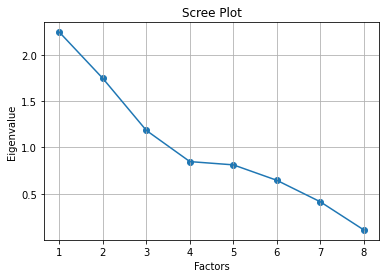

In [151]:
# SCREEPLOT (need pyplot)
plt.scatter(range(1,df_aux_sc.shape[1]+1),ev)
plt.plot(range(1,df_aux_sc.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [164]:
fa = FactorAnalyzer(3, rotation="Varimax")
fa.fit(df_aux_sc)
fa.get_factor_variance()
fa.loadings_

array([[-0.09765054,  0.03563914,  0.3461792 ],
       [ 0.02921651,  0.00295412,  0.9416245 ],
       [ 0.95224143,  0.02930398, -0.04528181],
       [ 0.06697074, -0.01289168,  0.66158092],
       [ 0.9413444 , -0.06541175, -0.04524626],
       [ 0.15629178,  0.85595153,  0.00349184],
       [-0.03187346,  0.84764248,  0.04329939],
       [ 0.54994559,  0.1356584 ,  0.00159061]])

In [165]:
fa.get_factor_variance()

(array([2.13565053, 1.47613648, 1.45017329]),
 array([0.26695632, 0.18451706, 0.18127166]),
 array([0.26695632, 0.45147338, 0.63274504]))

### Análise Fatorial Confirmatória

In [166]:
model_dict = {"F1": ["V1", "V2","V3","V4"],
              "F2": ["V6", "V7", "V8"],
              "F3": ['V5']}
model_spec = ModelSpecificationParser.parse_model_specification_from_dict(df_aux_sc, model_dict)
cfa = ConfirmatoryFactorAnalyzer(model_spec, disp=True)
cfa.fit(df_aux_sc)
cfa.loadings_.round(2)


array([[ -6.67,   0.  ,   0.  ],
       [ -6.67,   0.  ,   0.  ],
       [ -5.78,   0.  ,   0.  ],
       [ -6.18,   0.  ,   0.  ],
       [  0.  , -24.12,   0.  ],
       [  0.  ,  24.21,   0.  ],
       [  0.  , -17.63,   0.  ],
       [  0.  ,   0.  , -20.72]])

In [167]:
cfa.factor_varcovs_

array([[1.        , 1.11216026, 1.12657273],
       [1.11216026, 1.        , 1.06206829],
       [1.12657273, 1.06206829, 1.        ]])

In [168]:
# Calculo dos autovalores
sum(pd.DataFrame(cfa.loadings_.round(2)).iloc[:,0]**2)+sum(pd.DataFrame(cfa.loadings_.round(2)).iloc[:,1]**2)+sum(pd.DataFrame(cfa.loadings_.round(2)).iloc[:,2]**2)

2068.6124

In [172]:
def percentage(part, whole):
  return 100 * float(part)/float(whole)

percentage(sum(pd.DataFrame(cfa.loadings_.round(2)).iloc[:,2]**2),whole=20.193300000000004)

2126.043786800572

In [173]:
fact_trans = pd.DataFrame(cfa.fit_transform(df_aux_sc))
um = (fact_trans.iloc[:,0]-min(fact_trans.iloc[:,0]))/(max(fact_trans.iloc[:,0])-min(fact_trans.iloc[:,0]))
dois = (fact_trans.iloc[:,1]-min(fact_trans.iloc[:,1]))/(max(fact_trans.iloc[:,1])-min(fact_trans.iloc[:,1]))
tres = (fact_trans.iloc[:,2]-min(fact_trans.iloc[:,2]))/(max(fact_trans.iloc[:,2])-min(fact_trans.iloc[:,2]))

In [174]:
Indicador_Norm = pd.DataFrame(pd.concat([um,dois,tres],axis=1))

In [175]:
Indicador_Norm = np.where(Indicador_Norm < 0, 0, Indicador_Norm)
Indicador_Norm = np.where(Indicador_Norm > 1, 1, Indicador_Norm)
Indicador_Norm 


array([[0.70250143, 0.248369  , 0.9487019 ],
       [0.59123126, 0.62036033, 0.99487233],
       [0.83147999, 0.56824061, 0.99762629],
       ...,
       [0.92606347, 0.15075063, 0.80804905],
       [0.9797822 , 0.40673034, 0.85302725],
       [0.9482067 , 0.39771369, 0.85822837]])

In [ ]:
Indicador_Final = []

In [ ]:
 #A list holds the SSE values for each k
sse = []
for k in range(1, 21):
        kmeans = KMeans(n_clusters=k,max_iter=300)
        kmeans.fit(df_aux_sc)
        sse.append(kmeans.inertia_)


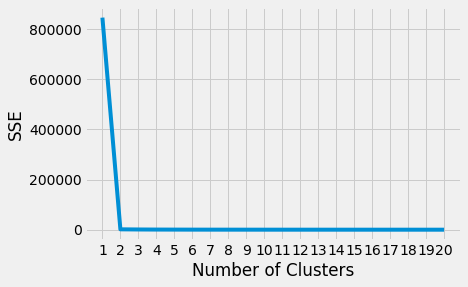

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 21), sse)
plt.xticks(range(1, 21))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

#### Esse resultado abaixo mostra o numero de grupos ótimo igual a 5.

In [ ]:
kl = KneeLocator(
        range(1, 21), sse, curve="convex", direction="decreasing"
    )
kl.elbow

2

In [ ]:
kmeans = KMeans(
   init="random",
   n_clusters=2,
   n_init=10,
   max_iter=400,
   random_state=42
)

In [ ]:
kresultado = kmeans.fit(df_aux_sc)

In [ ]:
df_aux_sc["segKmeans"] = kresultado.labels_

#### Visualizando o resultado K-means

In [ ]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_aux_sc)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df_aux_sc[['segKmeans']]], axis = 1)

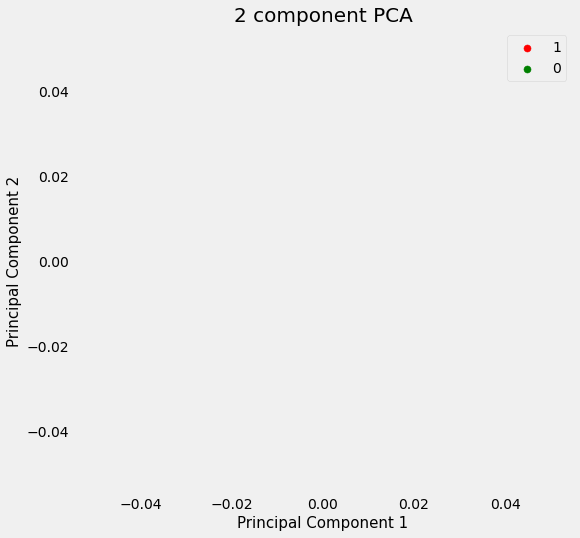

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = df_aux_sc.segKmeans.unique()
colors = ['r', 'g', 'b', 'black', 'cyan']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['segKmeans'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_))#loadings

,0,1
0,0.000375,0.003666
1,0.030070,-0.005476
2,0.030214,-0.005368
3,0.002437,0.006022
4,0.002595,0.006323
5,0.002779,0.006576
6,0.002457,0.005945
7,0.002183,0.004901
8,0.004019,0.010933
9,0.004214,0.006853


In [ ]:
df_aux_sc["SegKmeans"] = df.segKmeans

In [ ]:
tabulacao = df_aux_sc.groupby('SegKmeans').mean()
tabulacao

,QtdeVendida,VlVendaLiquido,VlVendaBruto,VlTotalBruto,VlTotalLiquido,VlImpostos,VlReceitaLiquida,VlLogTranspCubico,VlLogArmazenagem,VlLogCustoDistribuicao,CMV,VlFunding,VlDespVenCustoReprFuncionario,VlDespVenCustoVender,VlDespVenCustoComissao,VlMrgContribuicao,VlDescTotal,VlMrgBruta,VlEncargosVendor,VlGapVendor
SegKmeans,,,,,,,,,,,,,,,,,,,,
0,0.000094,0.084998,0.085947,0.004196,0.004505,0.005017,0.038638,0.003944,0.008943,0.015623,0.003339,0.000659,0.000372,0.003746,0.011825,0.090332,0.012907,0.076038,0.000896,0.000348
1,0.000826,0.005512,0.005711,0.000570,0.000597,0.000692,0.034921,0.000788,0.002099,0.005723,0.000448,0.000183,0.000496,0.000493,0.002400,0.085127,0.002662,0.068149,0.000029,0.000032
2,0.000023,0.325371,0.326086,0.012195,0.013279,0.014555,0.047014,0.012652,0.019749,0.031251,0.010248,0.001796,0.000000,0.000097,0.026095,0.099263,0.023645,0.090145,0.007890,0.003994
3,0.147326,0.029461,0.030977,0.347681,0.369466,0.392389,0.386385,0.261483,0.590537,0.302528,0.344819,0.356177,0.000000,0.010370,0.610123,0.521336,0.083333,0.583537,0.000070,0.099253
4,0.055381,0.026072,0.027710,0.043458,0.045252,0.041002,0.073192,0.048027,0.110280,0.089146,0.033811,0.022393,0.000000,0.009470,0.126962,0.138736,0.159947,0.139937,0.001113,0.005269


Text(0.5, 6.719999999999981, 'Features')

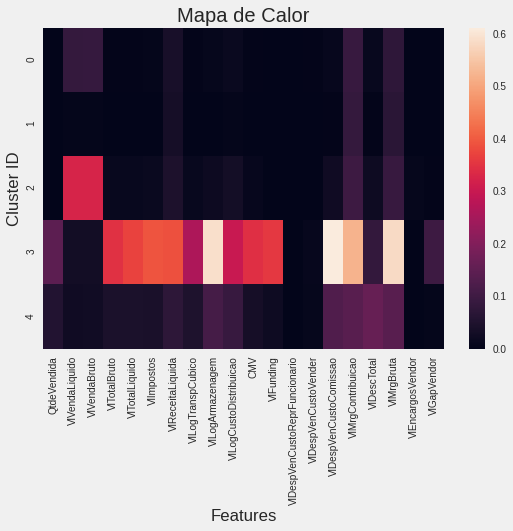

In [ ]:
fig, ax=plt.subplots()
sns.heatmap(tabulacao, ax=ax, annot = False);
ax.set_title("Mapa de Calor");
ax.set_ylabel("Cluster ID");
ax.set_xlabel("Features")

In [ ]:
df_rfv = df.groupby